In [8]:
import time
import numpy as np
import matplotlib
import pandas as pd
from shap import TreeExplainer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from transparency.python.explainer.ensemble_tree import EnsembleTreeExplainer
from matplotlib import pyplot as plt

In [2]:
# Generating the input data

M = 10000       # rows (samples)
N = 6       # columns (features)

# randomized input features (Continuous, Multi-Value Discrete, and Binary OHE)
X1 = 10 * (np.random.rand(M,N//3))
X2 = np.random.randint(0,10,(M,N//3))
X3 = np.random.randint(0,2,(M,N//3))
X = np.concatenate([X1, X2, X3], axis=1)

# randomized weights
W = np.random.randint(-10, 10, (N, 1))
Intercept = np.random.randint(-10, 10, 1)

# output labels
y = (X @ W + Intercept).reshape(-1)

# inspecting output generation for the top nn rows
nn = 3
print(X[:nn])
print(W.T)
print(Intercept)
print(y[:nn])

[[6.73958077 1.48740227 4.         9.         0.         1.        ]
 [1.37559989 2.76302499 4.         9.         1.         0.        ]
 [4.57542578 8.11825443 5.         1.         0.         0.        ]]
[[ 3 -7  8  3  2  7]]
[1]
[76.80692643 46.78562478  0.89849631]


In [3]:
# Train-test-split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape

((8000, 6), (2000, 6))

In [4]:
# Training with hyper-parameter tuning

algo = RandomForestRegressor
# algo = GradientBoostingRegressor

param_grid = {
    'n_estimators': [20, 30],
    'max_depth': [20, 30]
}

rf_reg = GridSearchCV(algo(), param_grid, cv=2, verbose=1)
model = rf_reg.fit(X_train, y_train)

regressor_model = model.best_estimator_
print('best model params:', model.best_params_)
y_test_hat = regressor_model.predict(X_test)
print('r2 score = ', r2_score(y_test, y_test_hat))

Fitting 2 folds for each of 4 candidates, totalling 8 fits
best model params: {'max_depth': 30, 'n_estimators': 30}
r2 score =  0.9878316519619825


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    2.0s finished


In [5]:
# SHAP explainer results

time0 = time.perf_counter()
explainer = TreeExplainer(regressor_model)
shap_values = explainer.shap_values(X_test)
time1 = time.perf_counter()
print('Elapsed time:', time1 - time0)
print(shap_values.shape)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


Elapsed time: 66.025929023
(2000, 6)


In [6]:
# Transparency EnsembleTreeExplainer
time0 = time.perf_counter()
expl = EnsembleTreeExplainer(regressor_model)
contributions, contrib_intercept = expl.predict(X_test)
time1 = time.perf_counter()
print('Elapsed time:', time1 - time0)
print(contributions.shape)

Elapsed time: 0.27040049500000407
(2000, 6)


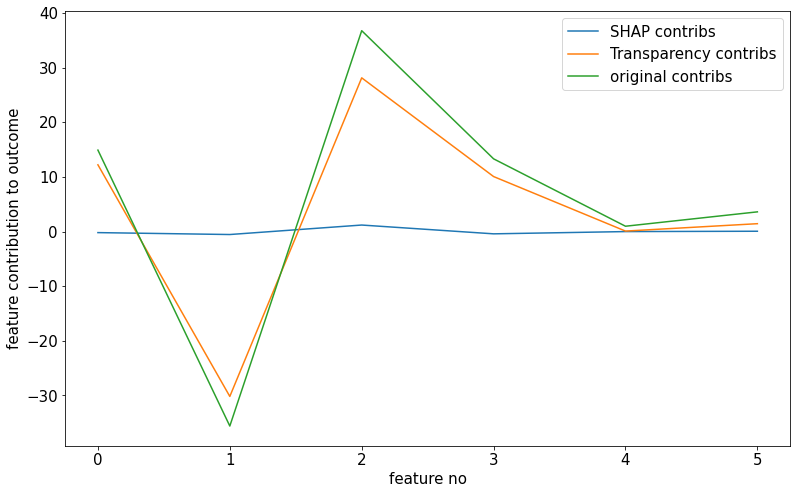

In [10]:
# Plotting the results

origingal_linear_contribs = np.mean(X_test*W.T, axis=0)
shap_contribs = np.mean(shap_values, axis=0)
transparency_contribs = np.mean(contributions, axis=0)

font = {'size'   : 15}
matplotlib.rc('font', **font)
plt.figure(figsize=(13,8))
plt.plot(shap_contribs, label='SHAP contribs')
plt.plot(transparency_contribs, label='Transparency contribs')
plt.plot(origingal_linear_contribs, label='original contribs')
plt.xlabel('feature no')
plt.ylabel('feature contribution to outcome')
plt.legend()

In [11]:
# Sum of feature contributions

print(np.mean(y_test_hat))
print(np.mean((np.sum(contributions, axis=1) + contrib_intercept) - y_test_hat))
print(np.mean(np.sum(shap_values, axis=1) - y_test_hat + np.mean(y_test_hat)))

34.844216233143236
5.300412886377615e-16
0.07031170100450577


In [12]:
# Contribution of Intercept

print('contrib_intercept_transparency', [contrib_intercept])
print('pred[0]', regressor_model.predict(np.array([[0] * N])))
print('true intercept', Intercept)

contrib_intercept_transparency [13.097393897789518]
pred[0] [13.0973939]
true intercept [1]
